<a href="https://colab.research.google.com/github/luanavsr/Estudos_Riscos/blob/main/VaR_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value at Risk (VaR) e Backtesting
O objetivo desse código é calcular o VaR Histórico de uma carteira e verificar se as perdas previstas pelo VaR ao longo do tempo, são  subestimados ou superiores as perdas máximas esperadas originalmente.

Passo a passo:


*   Baixar dados dos preços dos ativos
*   Definir os pesos de cada ativo na carteira
*   Calcular os retornos diários da carteira
*   Calcular o VaR Histórico diário da carteira (95% e 99%)
*   Comparar os resultados finais




In [39]:
# Instalando os pacotes

!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


[*********************100%%**********************]  4 of 4 completed


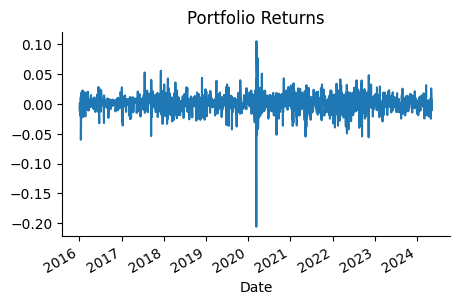

In [40]:
# @title Baixando os dados de preço do BTC, S&P500, Ibovespa e Nasdaq
tickers = ['BTC-USD', '^GSPC', '^BVSP','^IXIC']
df_prices = yf.download(tickers, start='2016-01-01', end= '2024-05-14')['Adj Close']

# Calculando os retornos em log, para retorno simples use: data_df.pct_change().dropna()
df_returns = df_prices.apply(np.log).diff().dropna()

# Definindo o peso de cada ativo no portfólio (equal weights)
weights = [1 / df_returns.columns.size] * df_returns.columns.size

# Calculando o retorno diário do portfólio e transformando em dataframe
port_returns = df_returns.mul(weights, axis=1).sum(axis=1)
port_returns = pd.DataFrame(port_returns, columns = ['Port Return'])

# Gráfico dos retornos diários do portfólio
port_returns['Port Return'].plot(kind='line', figsize=(5, 3), title='Portfolio Returns')
plt.gca().spines[['top', 'right',]].set_visible(False)


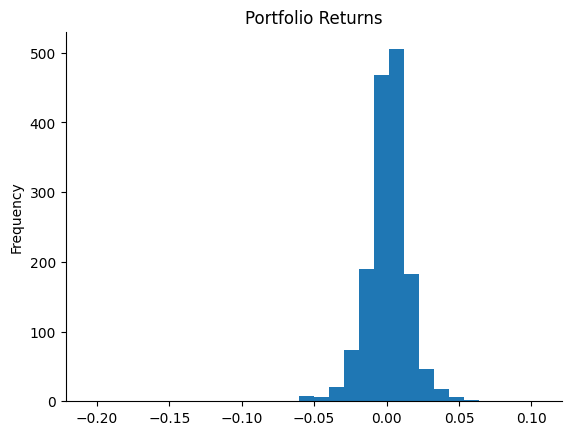

In [41]:
# Distribuição dos retornos diários do portfólio
port_returns['Port Return'].plot(kind='hist', bins=30, title='Portfolio Returns')
plt.gca().spines[['top', 'right',]].set_visible(False)

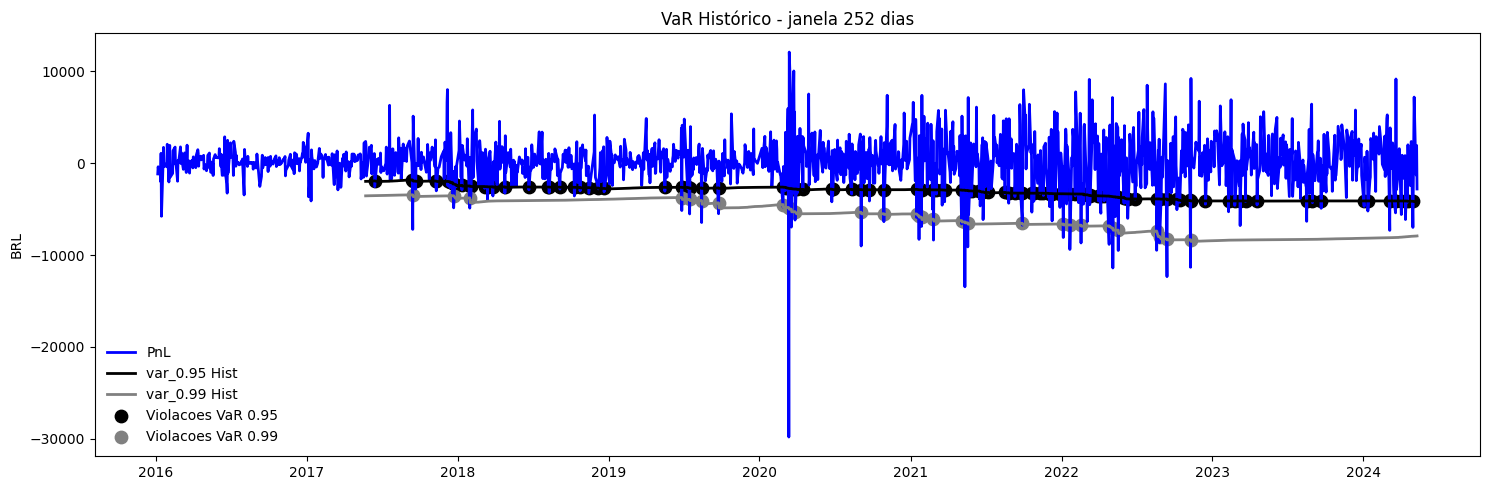

In [42]:
# Calculando o P&L do portfólio, considerando o valor inicial como 100k
initial_port_value = 100000
port_value = initial_port_value * (1 + port_returns).cumprod()
daily_pnl = port_value.diff()
daily_pnl = daily_pnl.rename(columns={'Port Return': 'PnL'})

# Calculando o VaR Histórco diário (95% e 99%)
nivel_c1 = 0.95
nivel_c2 = 0.99
janela = 252


def var_function(nivel_c1, nivel_c2, dados, janela):
  # ACalcula o VaR histórico iterativamente com base em uma janela indicada para dois níveis de confiança.
  # Args:
  #   nivel_c1 (float): Nível de confiança indicado  (entre 0 e 1).
  #   nivel_c1 (float): Nível de confiança indicado  (entre 0 e 1).
  #   dados (pd.DataFrame): DataFrame com os dados de PnL ou retornos.
  #   janela (int): Quantidade de dias para o cálculo inicial do VaR. Após isso, uma observação é adicionada a cada iteração.
  # Returns:
  #   pd.DataFrame: DataFrame com os resultados do VaR para os níveis de confiança indicados.
  dados = dados.dropna()
  var_resultados = pd.DataFrame(index= dados.index, columns=[f'var_{nivel_c1}', f'var_{nivel_c2}'])
  for i in range(len(dados)):
    j = janela + i
    if j >= len(dados):
      break
    df_sub = dados.iloc[:j]
    var_c1 = np.percentile(df_sub, 100-(nivel_c1*100))
    var_c2 = np.percentile(df_sub, 100-(nivel_c2*100))
    var_resultados.loc[dados.index[j]] = {f'var_{nivel_c1}': var_c1, f'var_{nivel_c2}': var_c2}

  return pd.concat([dados, var_resultados], axis=1)

df_resultados = var_function(nivel_c1, nivel_c2, daily_pnl, janela)

# Violações do VaR
df_resultados[f'viol_var_{nivel_c1}'] = np.where(df_resultados[f'var_{nivel_c1}']>df_resultados['PnL'],1,0)
df_resultados[f'viol_var_{nivel_c2}'] = np.where(df_resultados[f'var_{nivel_c2}']>df_resultados['PnL'],1,0)
viols_var_c1 =  df_resultados[df_resultados[f'viol_var_{nivel_c1}']!=0]
viols_var_c2 =  df_resultados[df_resultados[f'viol_var_{nivel_c2}']!=0]

# Gráfico PnL x VaRs x Violações
fig,ax = plt.subplots(figsize = (15,5))
ax.plot(df_resultados[['PnL']], color = 'blue', lw =2., label = 'PnL')
ax.plot(df_resultados[[f'var_{nivel_c1}']], color = 'black', lw =2., label = 'var_0.95 Hist')
ax.plot(df_resultados[[f'var_{nivel_c2}']], color = 'gray', lw =2., label = 'var_0.99 Hist')
ax.scatter(x = viols_var_c1.index, y = viols_var_c1[f'var_{nivel_c1}'], s =80, color ='black', label =f'Violacoes VaR {nivel_c1}')
ax.scatter(x = viols_var_c2.index, y = viols_var_c2[f'var_{nivel_c2}'], s =80, color ='gray', label =f'Violacoes VaR {nivel_c2}')
plt.title(f'VaR Histórico - janela {janela} dias')
plt
plt.xlabel('')
plt.ylabel('BRL')
ax.legend(fontsize=10, frameon=False)
plt.tight_layout()